In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
from torch import nn
from tqdm.auto import tqdm

sys.path.append('../../')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DSA/DSA')
from dmd import DMD
from stats import mase

# Functions

In [3]:
# Dataset class for time series prediction
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, sequence, target):
        self.sequence = sequence
        self.target = target

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, index):
        x = self.sequence[index]
        y = self.target[index]
        return x, y

# Prep

## Load Data

In [4]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

In [9]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]
directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

## Generate Training Data

In [10]:
session_info['drugStart']
wake_start = session_info['drugStart'][0]/2 # s
anesthesia_start = session_info['drugStart'][1] - 60*5 # s
start_times = {'wake': wake_start}
# window_length = 0.5*60 # s
window_length = 2.5*60 # s
area = 'vlPFC'
if area == 'all':
    indices = np.arange(electrode_info['area'])
else:
    indices = np.where(electrode_info['area'] == area)[0]
    
subsample = 5

In [11]:
# seq_length = 1 # s
seq_length = 5 # s
spacing = subsample*dt # s
num_seqs = int(((int(window_length/dt) - int(seq_length/dt) -1)/subsample)/int(spacing/(dt*subsample)))
iterator = tqdm(total=len(start_times)*num_seqs)
datasets = {}
for key, start_time in start_times.items():
    lfp_window = load_window_from_chunks(start_time, start_time + window_length, directory, indices)
    
    data = np.zeros((num_seqs, int(seq_length/(dt*subsample)), len(indices)))
    labels = np.zeros((num_seqs, int(seq_length/(dt*subsample)), len(indices)))
    for i in range(num_seqs):
        data[i] = lfp_window[i*int(spacing/dt):i*int(spacing/dt) + int(seq_length/dt)][np.arange(0, int(seq_length/dt), subsample)]
        labels[i] = lfp_window[i*int(spacing/dt) + 1:i*int(spacing/dt) + int(seq_length/dt) + 1][np.arange(0, int(seq_length/dt), subsample)]
        iterator.update()
    datasets[key] = TimeSeriesDataset(torch.from_numpy(data), torch.from_numpy(labels))
iterator.close()

  0%|          | 0/28999 [00:00<?, ?it/s]

In [12]:
dt = subsample*dt

# Define LSTM Model

In [13]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None, c0=None):
        """
          Given an imput sequence x from time 0:t, predict the value at each subsequent timestep
        """
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hiddens = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return (out,) + hiddens
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train

In [14]:
key = 'wake'
dataset = datasets[key]

In [15]:
device = 'cuda'
dtype = torch.FloatTensor

context_length = 0

batch_size = 32
train_percent = 0.8

train_size = int(train_percent*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# Set the hyperparameters
MODEL_TYPE = 'LSTM'

input_size = train_dataset[0][0].shape[-1]  # Input size for each time step
hidden_size = 64  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = train_dataset[0][0].shape[-1]  # Output size

# Create the LSTM model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# put everything on gpu
model.to(device)

LSTMModel(
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
)

In [17]:
print(f"{MODEL_TYPE} has {count_parameters(model)} trainable parameters")

LSTM has 70720 trainable parameters


In [18]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [19]:
# torch.autograd.set_detect_anomaly(True)
EPOCHS = 10
test_step = 1
opt_model = None
min_loss = np.Inf

# =======================
# ONE STEP PREDICTION
# =======================
num_batches = int(np.ceil(len(train_dataset)/batch_size))
loss_curve = np.zeros(EPOCHS*num_batches)
iterator = tqdm(total=EPOCHS*num_batches)
for epoch in range(EPOCHS):
    for i, (batch_data, labels) in enumerate(train_data_loader):
        batch_data = batch_data.type(dtype).to(device)
        labels = labels.type(dtype).to(device)

        # batch_data = batch_data[:, :10]
        # labels = labels[:, :10]

        optimizer.zero_grad()

        if MODEL_TYPE == 'causal-transformer-encoder':
            outputs, memory = model(batch_data)
        elif MODEL_TYPE == 'LSTM':
            outputs, hidden_h, hidden_c = model(batch_data)


        loss = criterion(outputs[:, context_length:], labels[:, context_length:])

        # start = datetime.now()
        loss.backward()
        # end = datetime.now()
        # print(f"Gradient elapsed time = {(end - start).total_seconds():.5f}")

        # Adjust learning weights
        # start = datetime.now()
        optimizer.step()
        # end = datetime.now()
        # print(f"Optimizer step elapsed time = {(end - start).total_seconds():.5f}")

        loss_curve[epoch*num_batches + i] = loss.item()

        iterator.update()

    if (epoch + 1) % test_step == 0:
        num_test_batches = int(np.ceil(len(test_dataset)/batch_size))
        total_loss = 0
        final_step_loss = 0
        for batch_data, labels in test_data_loader:
            batch_data = batch_data.type(dtype).to(device)
            labels = labels.type(dtype).to(device)

            if MODEL_TYPE == 'causal-transformer-encoder':
                outputs, memory = model(batch_data)
            elif MODEL_TYPE == 'LSTM':
                outputs, hidden_h, hidden_c = model(batch_data)

            total_loss += criterion(outputs[:, context_length:], labels[:, context_length:]).item()
            final_step_loss += criterion(outputs[:, -1], labels[:, -1]).item()

        total_loss /= num_test_batches
        final_step_loss /= num_test_batches
        print("-"*20)
        print(f"EPOCH {epoch + 1}")
        print(f"train loss = {loss_curve[epoch*num_batches:(epoch + 1)*num_batches].mean():.5f}")
        print(f"test loss = {total_loss:.5f}")
        print(f"test loss final step = {final_step_loss:.5f}")
        if total_loss < min_loss:
            min_loss = total_loss
            opt_model = deepcopy(model)
            # torch.save(transformer.state_dict(), os.path.join(save_path, f"opt_model"))
            # pd.to_pickle(transformer.params, os.path.join(save_path, f"opt_params"))
iterator.close()

  0%|          | 0/7250 [00:00<?, ?it/s]

--------------------
EPOCH 1
train loss = 0.00129
test loss = 0.00038
test loss final step = 0.00036
--------------------
EPOCH 2
train loss = 0.00030
test loss = 0.00024
test loss final step = 0.00023
--------------------
EPOCH 3
train loss = 0.00021
test loss = 0.00019
test loss final step = 0.00019
--------------------
EPOCH 4
train loss = 0.00018
test loss = 0.00017
test loss final step = 0.00016
--------------------
EPOCH 5
train loss = 0.00015
test loss = 0.00014
test loss final step = 0.00014
--------------------
EPOCH 6
train loss = 0.00014
test loss = 0.00013
test loss final step = 0.00012
--------------------
EPOCH 7
train loss = 0.00012
test loss = 0.00012
test loss final step = 0.00011
--------------------
EPOCH 8
train loss = 0.00011
test loss = 0.00011
test loss final step = 0.00010
--------------------
EPOCH 9
train loss = 0.00010
test loss = 0.00010
test loss final step = 0.00010
--------------------
EPOCH 10
train loss = 0.00010
test loss = 0.00009
test loss final step

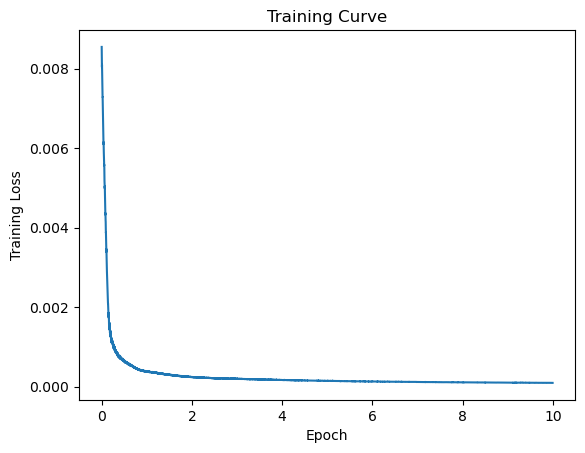

In [22]:
plt.plot(np.arange(len(loss_curve))[:iterator.last_print_n]/num_batches, loss_curve[:iterator.last_print_n])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Curve')
plt.show()

# One Step Testing

In [40]:
# FINAL TEST ONE STEP

all_test_outputs = np.zeros((len(test_dataset), int(seq_length/dt), test_dataset[0][0].shape[-1]))
all_test_labels = np.zeros((len(test_dataset), int(seq_length/dt), test_dataset[0][0].shape[-1]))

index = 0
for batch_data, labels in tqdm(test_data_loader):
    batch_data = batch_data.type(dtype).to(device)
    labels = labels.type(dtype).to(device)

    if MODEL_TYPE == 'transformer':
        outputs = opt_model(batch_data, src_mask=src_mask)
    elif MODEL_TYPE == 'LSTM':
        outputs, hidden_h, hidden_c = opt_model(batch_data)

    all_test_outputs[index:index + outputs.shape[0]] = outputs.detach().cpu().numpy()
    all_test_labels[index:index + outputs.shape[0]] = labels.detach().cpu().numpy()
    index += outputs.shape[0]

  0%|          | 0/182 [00:00<?, ?it/s]

/om2/user/eisenaj/anaconda/envs/dynamical-trajectories/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [43]:
for batch_data, labels in train_data_loader:
    break
dmd = DMD(batch_data, n_delays=50, rank=3000, device='cuda')
dmd.fit()

In [44]:
num_preds = 32
preds = dmd.predict(all_test_labels[:num_preds]).cpu()

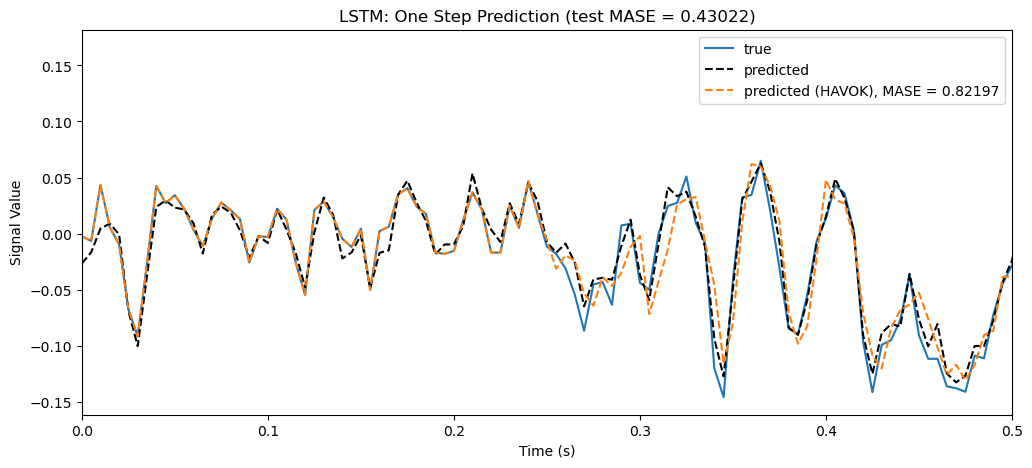

In [46]:
plt.figure(figsize=(12, 5))
plt.plot((np.arange(int(seq_length/dt))*dt)[context_length:], all_test_labels[0, :, 0], label='true')
plt.plot((np.arange(int(seq_length/dt))*dt)[context_length:], all_test_outputs[0, :, 0], c='k', linestyle='--', label=f'predicted')

plt.plot((np.arange(int(seq_length/dt))*dt)[context_length:], preds[0, context_length:, 0], c='C1', linestyle='--', label=f'predicted (HAVOK), MASE = {mase(all_test_labels[:num_preds], preds):.5f}')
# plt.plot((np.arange(seq_length)*system_kwargs['dt'])[1:], all_test_labels[0, :-1, 0], alpha=0.6, label=f'persistence baseline (test MSE = {((labels[:, :-1] - labels[:, 1:])**2).mean():.5f})')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.title(f"{MODEL_TYPE}: One Step Prediction (test MASE = {mase(all_test_labels, all_test_outputs):.5f})")
plt.xlim([0, 0.5])
plt.show()

# Chained

In [32]:
context_length = 100

In [33]:
# FINAL TEST CHAINED
reseed = int(seq_length/dt)

all_test_outputs = np.zeros((len(test_dataset), int(seq_length/dt), test_dataset[0][0].shape[-1]))
all_test_labels = np.zeros((len(test_dataset), int(seq_length/dt), test_dataset[0][0].shape[-1]))
index = 0
for batch_data, labels in tqdm(test_data_loader):
    batch_data = batch_data.type(dtype).to(device)
    labels = labels.type(dtype).to(device)

    if MODEL_TYPE == 'transformer':
        pass
    elif MODEL_TYPE == 'LSTM':
        outputs = torch.zeros(batch_data.shape).type(dtype).to(device)
        hidden_h, hidden_c = None, None
        for t in range(int(seq_length/dt)):
            if (t < context_length) or t % reseed == 0:
                outputs_t, hidden_h, hidden_c = opt_model(batch_data[:, [t]], hidden_h, hidden_c)
            else:
                outputs_t, hidden_h, hidden_c = opt_model(outputs[:, [t - 1]].to(device), hidden_h, hidden_c)
            outputs[:, [t]] = outputs_t

    all_test_outputs[index:index + outputs.shape[0]] = outputs.detach().cpu().numpy()
    all_test_labels[index:index + outputs.shape[0]] = labels.detach().cpu().numpy()
    index += outputs.shape[0]

  0%|          | 0/182 [00:00<?, ?it/s]

/om2/user/eisenaj/anaconda/envs/dynamical-trajectories/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


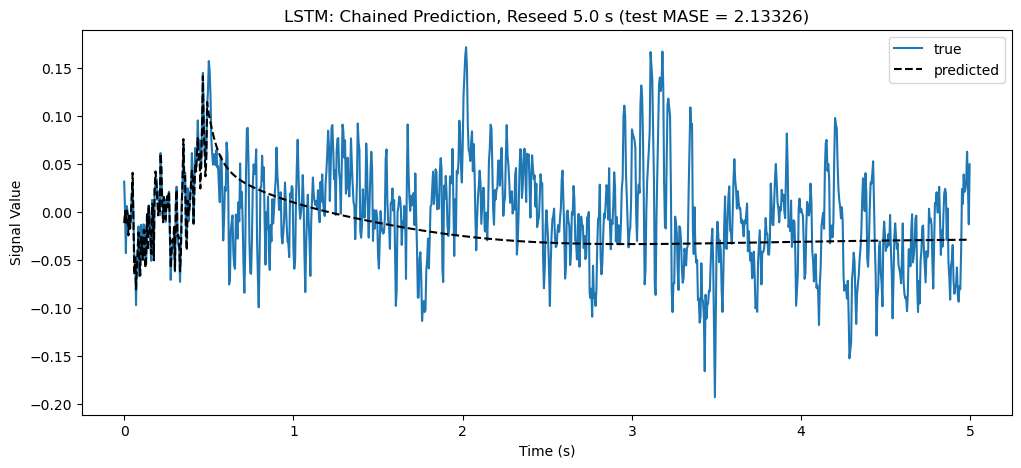

In [34]:
plt.figure(figsize=(12, 5))
time_vals = (np.arange(int(seq_length/dt))*dt)
plt.plot(time_vals, all_test_labels[0, :, 0], label='true')
# plt.plot(time_vals[:context_length +1], all_test_outputs[0, :context_length + 1, 0], c='purple', linestyle='--', label=f'predicted (context)')
plt.plot(time_vals[:], all_test_outputs[0, :, 0], c='k', linestyle='--', label=f'predicted')
# plt.plot(time_vals, labels[0, :-1, 0].detach().cpu().numpy(), alpha=0.6, label=f'persistence baseline (test MSE = {criterion(labels[:, :-1], labels[:, 1:]):.5f})')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.title(f"{MODEL_TYPE}: Chained Prediction, Reseed {reseed*dt:.1f} s (test MASE = {(np.abs(all_test_outputs - all_test_labels)).mean()/(np.abs(all_test_labels[:, :-1] - all_test_labels[:, 1:])).mean():.5f})")
plt.show()